In [12]:
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Import the sample AB data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/RecommendationAB/ab_sample.csv"
ab_data = pd.read_csv(file_url)

In [5]:
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [6]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

In [7]:
# Define underlying treatment effect function
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(X_data)

# Define the true coefficients to compare with
true_coefs = np.zeros(X_data.shape[1])
true_coefs[[1, 3, -2]] = [0.3, -0.2, 1]

In [8]:
# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

In [9]:
# Train EconML model
model = LinearIntentToTreatDRIV(
    model_y_xw = model_Y_X,
    model_t_xwz = model_T_XZ,
    flexible_model_effect = flexible_model_effect,
    featurizer = PolynomialFeatures(degree=1, include_bias=False)
)
model.fit(Y, T, Z=Z, X=X_data, inference="statsmodels")

In [10]:
# Compare learned coefficients with true model coefficients
coef_indices = np.arange(model.coef_.shape[0])
# Calculate error bars
coef_error = np.asarray(model.coef__interval()) # 95% confidence interval for coefficients
coef_error[0, :] = model.coef_ - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - model.coef_

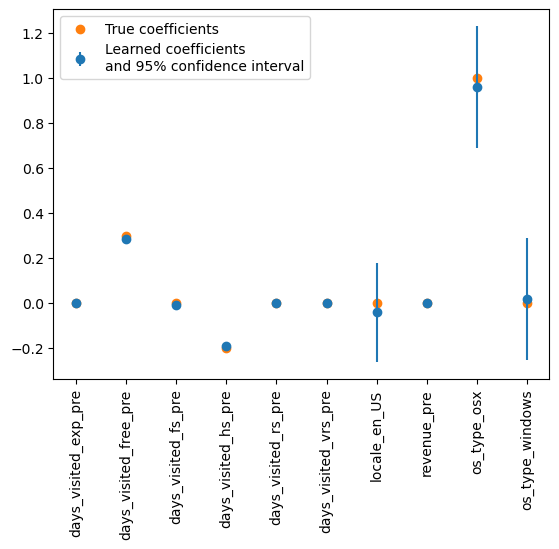

In [13]:
plt.errorbar(coef_indices, model.coef_, coef_error, fmt="o", label="Learned coefficients\nand 95% confidence interval")
plt.scatter(coef_indices, true_coefs, color='C1', label="True coefficients")
plt.xticks(coef_indices, X_data.columns, rotation='vertical')
plt.legend()
plt.show()

In [14]:
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
days_visited_exp_pre,-0.001,0.007,-0.095,0.924,-0.014,0.013
days_visited_free_pre,0.284,0.007,38.292,0.0,0.27,0.299
days_visited_fs_pre,-0.009,0.007,-1.278,0.201,-0.022,0.005
days_visited_hs_pre,-0.19,0.007,-28.02,0.0,-0.203,-0.176
days_visited_rs_pre,0.001,0.007,0.113,0.91,-0.012,0.014
days_visited_vrs_pre,-0.002,0.007,-0.272,0.786,-0.015,0.011
locale_en_US,-0.042,0.113,-0.371,0.71,-0.264,0.18
revenue_pre,-0.0,0.0,-0.908,0.364,-0.0,0.0
os_type_osx,0.96,0.139,6.925,0.0,0.688,1.231
os_type_windows,0.018,0.138,0.127,0.899,-0.254,0.289


In [15]:
test_customers = X_data.iloc[:1000]
true_customer_TE = TE_fn(test_customers)
model_customer_TE = model.effect(test_customers)

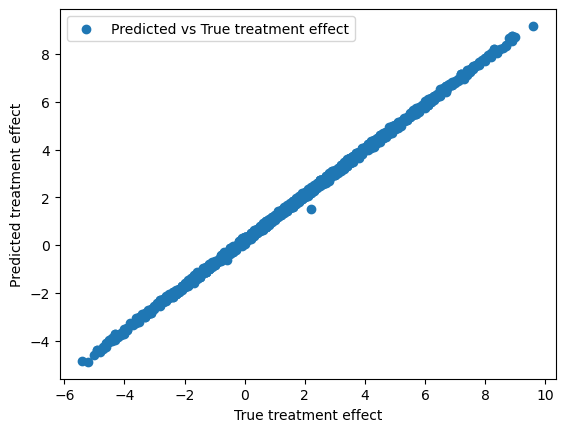

In [16]:
# How close are the predicted treatment effect to the true treatment effects for 1000 users?
plt.scatter(true_customer_TE, model.effect(test_customers), label="Predicted vs True treatment effect")
plt.xlabel("True treatment effect")
plt.ylabel("Predicted treatment effect")
plt.legend()
plt.show()

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


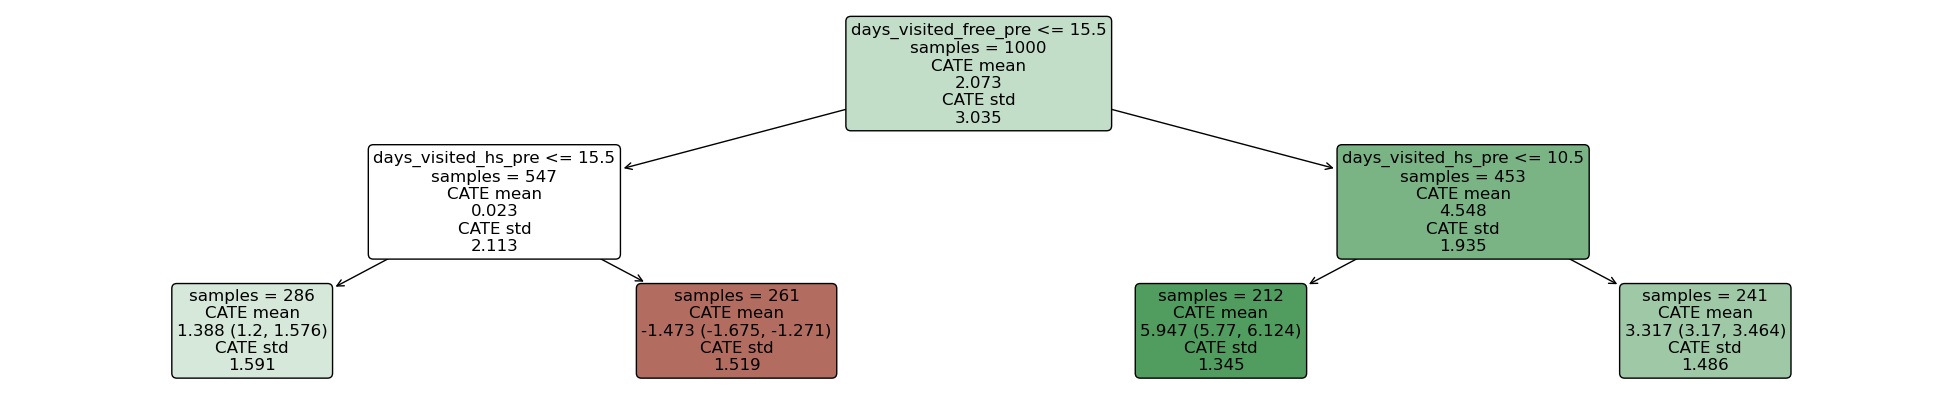

In [17]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, test_customers)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)

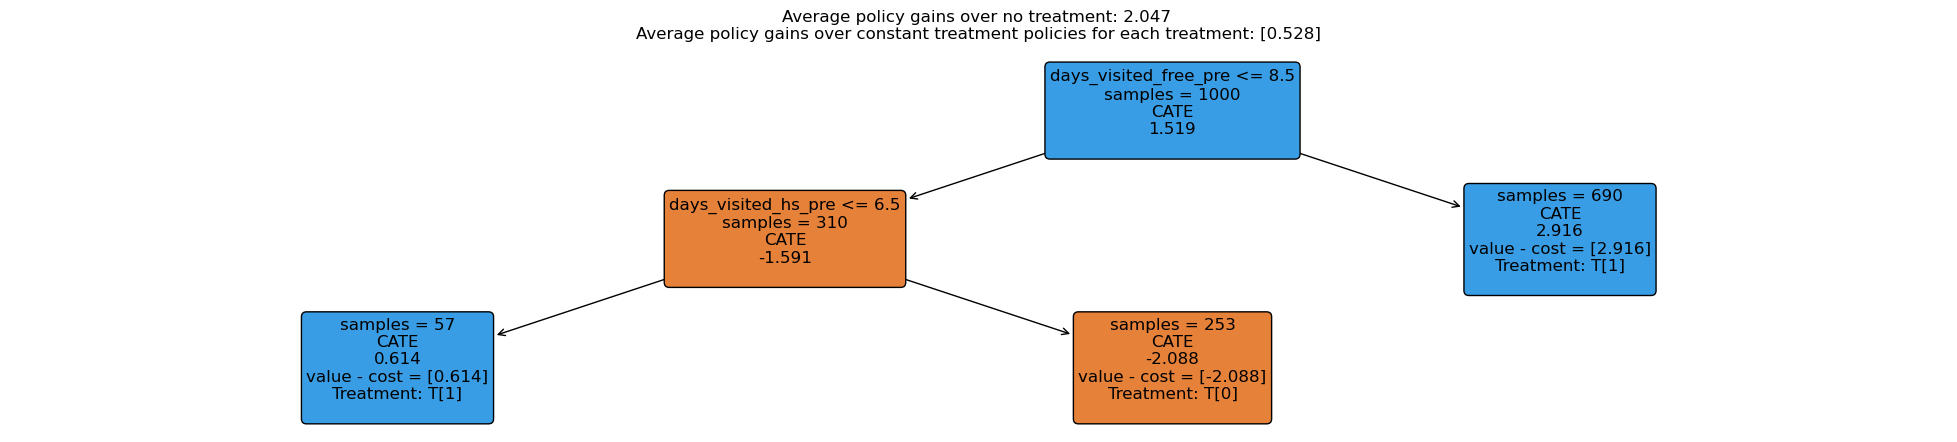

In [18]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, test_customers, sample_treatment_costs=0.2)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X_data.columns, fontsize=12)